# Instalar librerias 

In [107]:
%pip install opencv-python matplotlib numpy scipy tqdm scikit-learn Rtree faiss-cpu scikit-image

Note: you may need to restart the kernel to use updated packages.


# Llamar librerias 

In [108]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tqdm
import sklearn  
import rtree
import faiss 
import os
from skimage import color , io

# Cargar data de features locales 

In [109]:
directory_path = directory_path = os.path.join("F:/", "DB2_Proyect", "portraits") 
features_path = os.getcwd()
images_names = os.listdir(directory_path)
file_name = "descriptors_color_2_opencv.npz"
load_path = os.path.join(os.getcwd(), "data",file_name)
features = np.load(load_path)



# Probar si se puede acceder a la ruta de imagenes instaladas

10509830.jpg


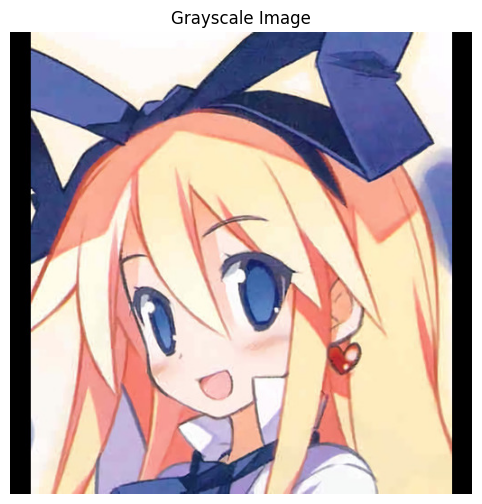

In [110]:

# Ruta de la imagen
image_index = 3654
image_path = os.path.join(directory_path, images_names[image_index])

# Cargar la imagen y convertirla a escala de grises
image = io.imread(image_path)


# Mostrar la imagen en escala de grises
print(images_names[image_index])
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

# Graficadora de resultados 

In [111]:
def display_images_in_grid(image_paths, grid_rows, grid_cols):
    """
    Muestra las imágenes en una cuadrícula de subplots con el nombre de la imagen como título.

    Parameters:
    image_paths (list): Lista de rutas de imágenes a mostrar.
    grid_rows (int): Número de filas en la cuadrícula.
    grid_cols (int): Número de columnas en la cuadrícula.
    """
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2))
    
    # Aplanar el arreglo de ejes para fácil iteración
    axes = axes.flatten()
    
    # Mostrar cada imagen en su posición correspondiente
    for i, image_path in enumerate(image_paths):
        
        if i < len(axes):  # Para evitar errores si hay más espacios que imágenes
            image = io.imread(image_path)
            
            # Determinar si la imagen es en escala de grises o a color
            if image.ndim == 2:
                # Escala de grises
                axes[i].imshow(image, cmap='gray')
            elif image.ndim == 3:
                # A color (RGB)
                axes[i].imshow(image)
            else:
                raise ValueError(f"La imagen {image_path} tiene un formato inesperado: {image.ndim} dimensiones.")
            
            # Extraer solo el nombre del archivo
            image_name = os.path.basename(image_path)
            
            # Establecer el título con el nombre de la imagen
            axes[i].set_title(image_name)
            axes[i].axis('off')
    
    # Desactivar cualquier subplot vacío
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


# Generador de Query

In [112]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(cell_image, P=8, R=1, method='uniform', bins=4):
    lbp_features = []
    for channel in range(3):  # RGB
        lbp = local_binary_pattern(cell_image[:, :, channel], P=P, R=R, method=method)
        # Calcular histograma
        hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
        # Normalizar
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.extend(hist)
    return np.array(lbp_features)  # 3 canales * 4 bins = 12

def extract_color_histogram(cell_image, bins=4):
    color_hist = []
    for channel in range(3):  # RGB
        hist, _ = np.histogram(cell_image[:, :, channel], bins=bins, range=(0, 256))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        color_hist.extend(hist)
    return np.array(color_hist)  # 3 canales * 4 bins = 12

def extract_hog_features_opencv(gray_cell, orientations=4, pixels_per_cell=(64, 64), cells_per_block=(1, 1)):
    winSize = (gray_cell.shape[1] // pixels_per_cell[1] * pixels_per_cell[1],
               gray_cell.shape[0] // pixels_per_cell[0] * pixels_per_cell[0])
    hog = cv2.HOGDescriptor(_winSize=winSize,
                            _blockSize=(pixels_per_cell[1]*cells_per_block[1],
                                        pixels_per_cell[0]*cells_per_block[0]),
                            _blockStride=(pixels_per_cell[1], pixels_per_cell[0]),
                            _cellSize=pixels_per_cell,
                            _nbins=orientations)
    hog_features = hog.compute(gray_cell)
    hog_features = hog_features.flatten()
    # Reducir a 4 dimensiones si es necesario
    if len(hog_features) > orientations:
        hog_features = np.mean(hog_features.reshape(-1, orientations), axis=0)
    elif len(hog_features) < orientations:
        hog_features = np.pad(hog_features, (0, orientations - len(hog_features)), 'constant')
    return hog_features

def process_image_opencv(image_path, orientations=4, pixels_per_cell=(64, 64), cells_per_block=(1, 1), 
                        P=8, R=1, lbp_bins=4, color_bins=4):
    image = io.imread(image_path)
    
    # Validar que la imagen sea RGB
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError(f"La imagen {image_path} no es RGB o no tiene 3 canales.")
    
    # Validar tamaño de la imagen (512x512)
    if image.shape[0] != 512 or image.shape[1] != 512:
        raise ValueError(f"La imagen {image_path} no tiene tamaño 512x512. Tamaño actual: {image.shape[:2]}")
    
    # Dividir la imagen en una cuadrícula de 8x8 (64 celdas de 64x64)
    grid_size = 8
    cell_height = image.shape[0] // grid_size
    cell_width = image.shape[1] // grid_size
    
    feature_matrix = []
    
    for row in range(grid_size):
        for col in range(grid_size):
            # Definir las coordenadas de la celda
            start_y = row * cell_height
            end_y = (row + 1) * cell_height
            start_x = col * cell_width
            end_x = (col + 1) * cell_width
            
            # Extraer la celda
            cell = image[start_y:end_y, start_x:end_x]
            
            # Convertir a escala de grises para HOG
            gray_cell = color.rgb2gray(cell)
            gray_cell_uint8 = (gray_cell * 255).astype('uint8')  # Convertir a uint8 para OpenCV
            
            # Extraer HOG usando OpenCV
            hog_features = extract_hog_features_opencv(gray_cell_uint8, orientations, pixels_per_cell, cells_per_block)
            # Asegurar que HOG contribuye con 4 dimensiones
            if len(hog_features) != orientations:
                # Reducir dimensionalidad de HOG mediante promedio si es necesario
                hog_features = np.mean(hog_features.reshape(-1, orientations), axis=0)
            
            # Extraer LBP
            lbp_features = extract_lbp_features(cell, P=P, R=R, method='uniform', bins=lbp_bins)
            # Reducir LBP a 4 dimensiones
            if len(lbp_features) > 4:
                lbp_features = lbp_features[:4]  # Seleccionar las primeras 4 dimensiones
            elif len(lbp_features) < 4:
                lbp_features = np.pad(lbp_features, (0, 4 - len(lbp_features)), 'constant')
            
            # Extraer Histograma de Color Local
            color_hist = extract_color_histogram(cell, bins=color_bins)
            # Reducir color_hist a 8 dimensiones
            if len(color_hist) > 8:
                color_hist = color_hist[:8]  # Seleccionar las primeras 8 dimensiones
            elif len(color_hist) < 8:
                color_hist = np.pad(color_hist, (0, 8 - len(color_hist)), 'constant')
            
            # Concatenar HOG + LBP + Color Histogram
            feature_vector = np.concatenate([hog_features, lbp_features, color_hist])
            # Asegurar que el feature_vector tiene exactamente 16 dimensiones
            if feature_vector.shape[0] != 16:
                raise ValueError(f"El vector de características de la celda ({row}, {col}) no tiene 16 dimensiones. Tiene {feature_vector.shape[0]} dimensiones.")
            
            feature_matrix.append(feature_vector)
    
    feature_matrix = np.array(feature_matrix)  # Shape: (64, 16)
    
    return image_path, feature_matrix

# Empezar con el proceso de sampling

In [113]:
print(len(features))

302652


# Esto servira para cargar los valores 

In [114]:
# Cargar el archivo
output_directory = os.path.join(os.getcwd(),"data")
data_name = 'features_data_2.npz' # Data ya en Vstack , usar para usada para obtener centroides 
path = os.path.join(output_directory,data_name)


loaded_data = np.load(path, allow_pickle=True)

# Acceder a los datos
total_features_index = loaded_data["total_features_index"].item()  # Convierte a diccionario
total_features = loaded_data["total_features"]  # Es un array de NumPy con todos los features stackeados en forma vertcial , uso solo para obetener centroides

print(len(total_features_index))
print(len(total_features))

302652
19369728


In [115]:
def key_generator(num):
    num = num//64
    return tuple((num*64 , num*64+64))

print(key_generator(2690))

(2688, 2752)


# Cargar dada de centroides y visual words

In [116]:
loading_path = os.path.join(os.getcwd(),"data")
visual_words_file ='visual_words_500_v2.npz'
vwords_path =os.path.join(loading_path,visual_words_file)
loaded_data = np.load(vwords_path, allow_pickle=True)

visual_words = loaded_data["visual_words"]

centroids = loaded_data["centroides"]

In [117]:
index =  np.where(visual_words == 3)[0]

test = visual_words[0:64]
clusters = set()
for idc in test:
    clusters.add(idc)
print(len(index))
print(len(clusters))

56190
47


# Armar indice inverso con Tf

In [118]:
from tqdm import tqdm

inverted_index = {}


for idx, cluster_idx in tqdm(enumerate(visual_words)):
    image_name = total_features_index[key_generator(idx)]
    if cluster_idx not in inverted_index:
        inverted_index[cluster_idx] = {}
    
    if image_name not in inverted_index[cluster_idx]:
        inverted_index[cluster_idx][image_name] = 1
    else:
        inverted_index[cluster_idx][image_name] += 1




19369728it [00:14, 1365268.71it/s]


In [119]:
s = 0
img_names = set()
for idx in clusters:
    img_names.update(inverted_index[idx].keys())

len(img_names)

299896

# Crear idf de los documentos/visual words 

In [120]:
import math as m
def calculate_idf(inverted_index, total_features_index):
    N = len(total_features_index)
    idf_vector = np.zeros(len(inverted_index))
    
    for idx, word_tf_dict in enumerate(inverted_index.values()):
        df = len(word_tf_dict)  
        idf_vector[idx] = np.log10(N / (df + 1))  
    
    return idf_vector
idf_inverted_index = calculate_idf(inverted_index=inverted_index , total_features_index=total_features_index)    


# Precalcular vectores tf de todas las imagenes

In [121]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def calculate_tf(inverted_index):
    # Inicializar diccionario con vectores numpy
    tf_dict = defaultdict(lambda: np.zeros(len(inverted_index)))
    
    # Calcular TF para cada cluster e imagen
    for cluster_id, cluster_images_tf in tqdm(inverted_index.items()):
        for img_name, tf in cluster_images_tf.items():
            tf_dict[img_name][cluster_id] = np.log1p(tf)
            
    return dict(tf_dict)

# Uso
tf_dict = calculate_tf(inverted_index)


100%|██████████| 500/500 [00:17<00:00, 28.19it/s]


In [122]:
print(np.where(tf_dict["1085951"]>0))# Verificar si los clusters no cero del vector tf


(array([  0,  28,  32,  42,  44,  61,  63,  68, 100, 116, 140, 142, 150,
       152, 171, 188, 198, 199, 200, 225, 226, 238, 239, 245, 280, 289,
       318, 329, 330, 349, 377, 390, 391, 400, 407, 424, 431, 449, 456,
       482]),)


# Precalcular vectores tf_idf y normalizarlos 

In [123]:
def prenormalization(tf_dict, idf_array):
    tf_idf = {}
    for img_name, tf_vector in tqdm(tf_dict.items()):
        tf_idf_vector = tf_vector * idf_array
        tf_idf_norm = np.linalg.norm(tf_idf_vector)
        tf_idf_vector = tf_idf_vector/tf_idf_norm
        tf_idf[img_name] = tf_idf_vector
    return tf_idf

tf_idf_dict = prenormalization(tf_dict=tf_dict, idf_array=idf_inverted_index)


100%|██████████| 302652/302652 [00:01<00:00, 195889.44it/s]


In [124]:
del tf_dict

In [125]:
print(np.where(tf_idf_dict["1085951"]>0)) # Verificar si los clusters no cero de vector tf_idf coninciden con los del tf

(array([  0,  28,  32,  42,  44,  61,  63,  68, 100, 116, 140, 142, 150,
       152, 171, 188, 198, 199, 200, 225, 226, 238, 239, 245, 280, 289,
       318, 329, 330, 349, 377, 390, 391, 400, 407, 424, 431, 449, 456,
       482]),)


In [126]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import heapq as pq

def normalize_query_descriptors(query_matrix):
    """
    Normaliza cada descriptor de 64 dimensiones de la query
    Args:
        query_matrix: Matriz de descriptores donde cada fila es un descriptor de 64 dimensiones
    Returns:
        Matriz normalizada de descriptores
    """
    # Asegurar que sea un array numpy
    query_matrix = np.array(query_matrix)
    
    # Calcular la norma L2 para cada descriptor
    norms = np.linalg.norm(query_matrix, axis=1, keepdims=True)
    
    # Evitar división por cero
    norms = np.maximum(norms, 1e-8)
    
    # Normalizar cada descriptor
    query_matrix_normalized = query_matrix / norms
    
    return query_matrix_normalized


def tf_idf_knn(query_matrix, k=10, inverted_index={}, tf_idf_dict={}, idf_array=[], centroids=centroids):
    # Crear y cachear NearestNeighbors
    if not hasattr(tf_idf_knn, 'nbrs'):
        tf_idf_knn.nbrs = NearestNeighbors(
            n_neighbors=1,
            algorithm='kd_tree',
            metric='euclidean',
            leaf_size=30,
            n_jobs=-1
        ).fit(centroids)
    
    # Procesar query en batches
    batch_size = 1000
    indices = []
    for i in range(0, len(query_matrix), batch_size):
        batch = query_matrix[i:i + batch_size]
        _, batch_indices = tf_idf_knn.nbrs.kneighbors(batch)
        indices.append(batch_indices)
    
    indices = np.concatenate(indices).flatten()
    
    # Calcular TF-query usando numpy
    unique_indices, counts = np.unique(indices, return_counts=True)
    tf_query = np.zeros(len(inverted_index))
    tf_query[unique_indices] = np.log1p(counts)
    
    # Normalizar query vector
    tf_idf_query_vector = tf_query * idf_array
    norm = np.linalg.norm(tf_idf_query_vector)
    if norm > 0:
        tf_idf_query_vector_normalized = tf_idf_query_vector/norm
    else:
        return [], set(), tf_idf_query_vector
    
    # Recolectar candidatos relevantes
    relevant_images = set().union(*[inverted_index[idx].keys() for idx in unique_indices])
    print(len(relevant_images))
    # Calcular similitudes en batch
    similarities = [(img_code, np.dot(tf_idf_query_vector_normalized, tf_idf_dict[img_code])) 
                   for img_code in relevant_images]
    
    # Obtener top-k usando sort en lugar de heap
    results = [img_code for img_code, sim in sorted(similarities, key=lambda x: x[1], reverse=True)[:k]]
    
    return results, relevant_images, tf_idf_query_vector_normalized
     
        




In [130]:

query_path = os.path.join(directory_path , "3504480.jpg")
_,query= process_image_opencv(query_path)
query_normalized = normalize_query_descriptors(query_matrix=query)


In [131]:
results , result_nombres , query_vec = tf_idf_knn(query_matrix=query_normalized ,k=10, inverted_index=inverted_index,tf_idf_dict=tf_idf_dict , idf_array=idf_inverted_index)


300068


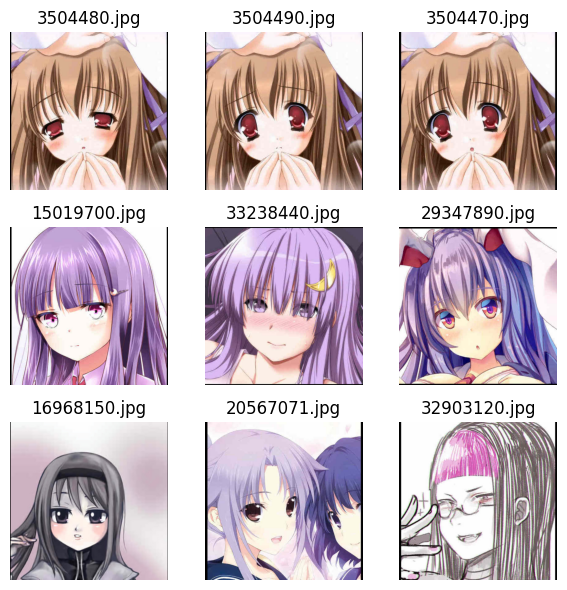

In [132]:
results = [os.path.join(directory_path,img_name +'.jpg') for img_name in results]
display_images_in_grid(results,3,3)

## LEGACY CODE NO CORRER ESTA PARTE 

In [ ]:
from tqdm import tqdm

def vtstack_clusters(features):
    total_features_index = {}
    total_features = []
    index = 0
    # Concatenamos todos los features en un solo array
    for image_name , matrix in tqdm(features.items()):
        size = len(matrix)
        total_features_index[image_name]=(index, index+size)
        total_features.extend(matrix)
        index+=size

    return total_features_index , total_features    
total_features_index , total_features = vtstack_clusters(features=features)

# Por si deseas guardar esto
#np.savez(path, 
 #        total_features_index=total_features_index, 
  #       total_features=np.array(total_features))
